<a href="https://colab.research.google.com/github/dibadabir/Project1_A24/blob/main/Second_Model_(ResNet_Versions).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [1]:
# Import Libraries
import os
import random
import numpy as np
from google.colab import drive
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
from tensorflow.keras import backend as K

# Mounting Google Drive

In [2]:
# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Define the paths

In [4]:
# Specify folders in Google Drive
cancerous_folder = "/content/drive/MyDrive/2nd Model/Cancerous_Lesions_Preprocessed"
noncancerous_folder = "/content/drive/MyDrive/2nd Model/Non_Cancerous_Lesions_Preprocessed"


# Verify that the folders exist
if not os.path.exists(cancerous_folder):
    raise FileNotFoundError(f"The folder '{cancerous_folder}' does not exist.")
if not os.path.exists(noncancerous_folder):
    raise FileNotFoundError(f"The folder '{noncancerous_folder}' does not exist.")

# Functions for Plotting the Evaluation Results

In [5]:
#Plot Training and Validation Loss and Accuracy
def plot_training_history(history):
    """Plots the training and validation loss and accuracy."""
    plt.figure(figsize=(12, 6))


    #Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()


    #Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()


    plt.tight_layout()
    plt.show()


#Confusion Matrix for Predictions (FP, FN, TP, TN)
def plot_confusion_matrix(y_true, y_pred_classes):
    """Plots the confusion matrix."""
    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["NonCancerous", "Cancerous"], yticklabels=["NonCancerous", "Cancerous"])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


#ROC-AUC Curve to show how well the model classifies between Normal and Lesion.
def plot_roc_auc(y_true, y_pred):
    """Plots the ROC-AUC curve."""
    fpr, tpr, _ = roc_curve(y_true, y_pred)  # Calculate False Positive Rate and True Positive Rate
    roc_auc = auc(fpr, tpr)  # Calculate AUC


    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for random guessing
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-AUC Curve')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()


#Classification Report - Precision, Recall, F1-score and Support
def generate_classification_report(y_true, y_pred_classes):
    """Generates a classification report."""
    report = classification_report(y_true, y_pred_classes, target_names=["NonCancerous", "Cancerous"])
    print("\nClassification Report:\n")
    print(report)

# Load Images

In [6]:
# Load and organize images
def load_images_from_folder(folder, label):
    return [(os.path.join(folder, img), label) for img in os.listdir(folder) if img.lower().endswith(('png', 'jpg', 'jpeg'))]

# Load all images and assign labels
cancerous_images = load_images_from_folder(cancerous_folder, 'Cancerous')
noncancerous_images = load_images_from_folder(noncancerous_folder, 'NonCancerous')

# Combine all images and labels
all_images = cancerous_images + noncancerous_images
random.seed(42)
random.shuffle(all_images)

# Split the data
image_paths, labels = zip(*all_images)
labels = np.array([1 if label == 'Cancerous' else 0 for label in labels])

X_train, X_test, y_train, y_test = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42, stratify=labels
)

# Version 1

In [ ]:
# Create datasets
def preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = preprocess_input(image)  # ResNet50 preprocessing
    return image

def load_data(image_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(lambda x, y: (preprocess_image(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    return dataset

train_dataset = load_data(X_train, y_train).batch(32).shuffle(buffer_size=1000).prefetch(tf.data.AUTOTUNE)
test_dataset = load_data(X_test, y_test).batch(32).prefetch(tf.data.AUTOTUNE)

# Define the ResNet-50 model
def create_resnet_model():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False  # Freeze the base model

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')  # Binary classification
    ])
    return model

# Compile the model
model = create_resnet_model()
model.compile(optimizer=Adam(learning_rate=0.0001),  # Reduced learning rate
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Class Weights (handle class imbalance)
class_weights = {0: 1.0, 1: 3.0}

# EarlyStopping and ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# Train the model
history = model.fit(train_dataset,
                    epochs=15,
                    validation_data=test_dataset,
                    class_weight=class_weights,
                    callbacks=[early_stopping, reduce_lr])

# Evaluate the model
test_loss, test_acc = model.evaluate(test_dataset)
print(f"\nTest accuracy: {test_acc:.2f}")

# Save the model
model_save_path = '/content/drive/MyDrive/skin_classification_resnet50_model.h5'
model.save(model_save_path)
print(f"\nModel saved to: {model_save_path}")


Mounted at /content/drive
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 309s 2s/step - accuracy: 0.5258 - loss: 1.8586 - val_accuracy: 0.5975 - val_loss: 1.1860 - learning_rate: 1.0000e-04
Epoch 2/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 34s 131ms/step - accuracy: 0.6393 - loss: 1.4065 - val_accuracy: 0.6900 - val_loss: 1.0121 - learning_rate: 1.0000e-04
Epoch 3/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 132ms/step - accuracy: 0.6718 - loss: 1.3150 - val_accuracy: 0.7050 - val_loss: 0.9556 - learning_rate: 1.0000e-04
Epoch 4/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 119ms/step - accuracy: 0.7058 - loss: 1.2300 - val_accuracy: 0.7175 - val_loss: 0.9367 - learning_rate: 1.0000e-04
Epoch 5/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 0.7243 - loss: 1.1527 - val_accuracy: 0.6975 - val_loss: 0.9549 - learning_rate: 1.0000e-04
Epoch 6/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 133ms/step - accuracy: 0.7370 - loss: 1.0882 - val_accuracy: 0.7350 - val_loss: 0.8832 - learning_

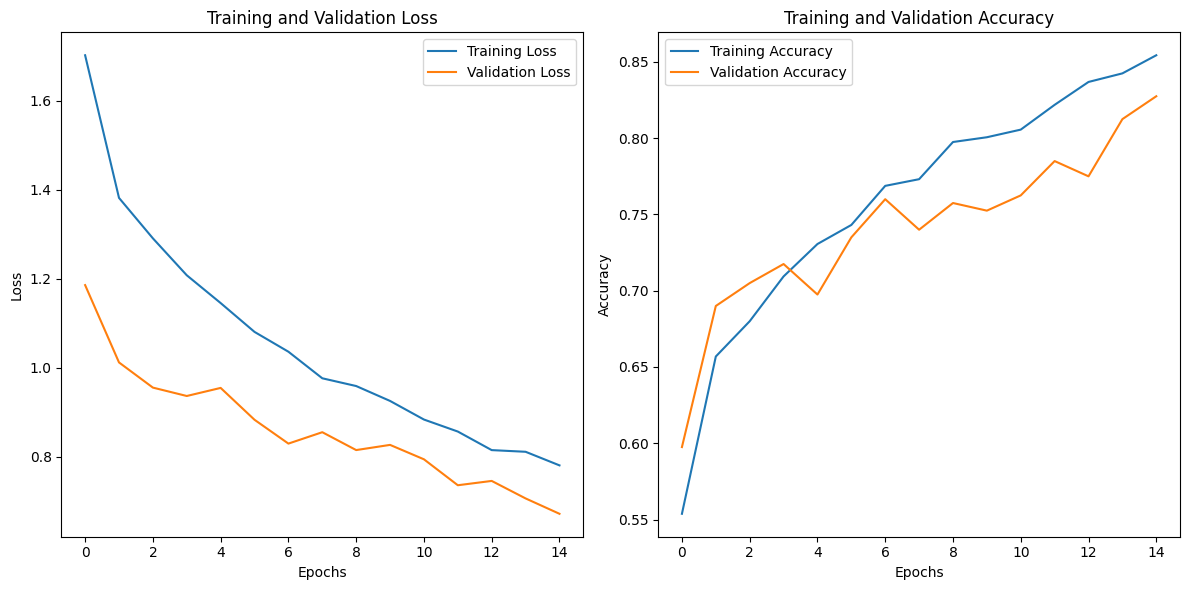

13/13 ━━━━━━━━━━━━━━━━━━━━ 18s 799ms/step


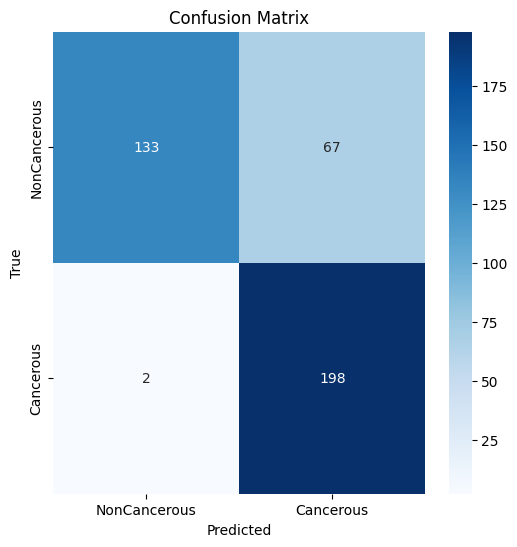

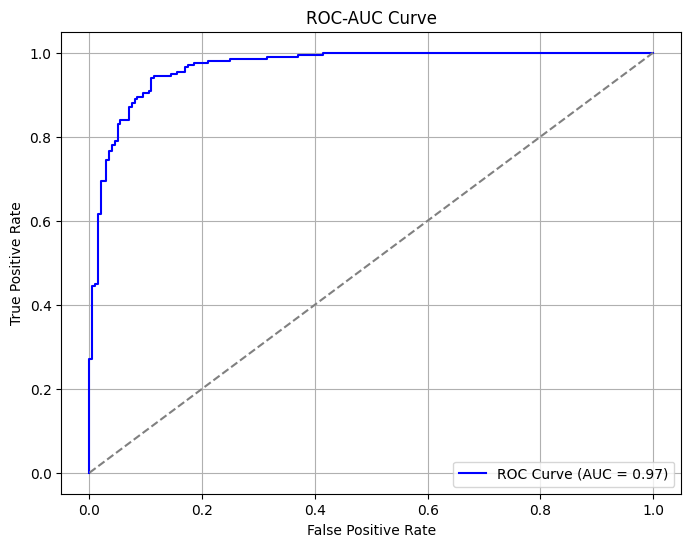


Classification Report:

              precision    recall  f1-score   support

      Normal       0.99      0.67      0.79       200
      Lesion       0.75      0.99      0.85       200

    accuracy                           0.83       400
   macro avg       0.87      0.83      0.82       400
weighted avg       0.87      0.83      0.82       400



In [ ]:
#Plot Training History
plot_training_history(history)


#Evaluate the model and generate predictions
y_pred = model.predict(test_dataset)
y_pred_classes = (y_pred > 0.5).astype("int32").flatten()  #If greater than 0.5, it assigns it as Lesion (1) and if less than 0.5 its assigned as normal (0)
y_true = np.concatenate([y for x, y in test_dataset], axis=0)  # Extract true labels from the dataset


#Confusion Matrix for Predictions (FP, FN, TP, TN)
plot_confusion_matrix(y_true, y_pred_classes)


#ROC-AUC Curve to show how well the model classifies between Normal and Lesion.
plot_roc_auc(y_true, y_pred)


#Classification Report - Precision, Recall, F1-score and Support
generate_classification_report(y_true, y_pred_classes)

# Version 2

changes:

*   Using Focal Loss instead of Binary Cross-Entropy
*   Threshold tuning using ROC curve



In [ ]:
# Create datasets
def preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = preprocess_input(image)  # ResNet50 preprocessing
    return image

def load_data(image_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(lambda x, y: (preprocess_image(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    return dataset

train_dataset = load_data(X_train, y_train).batch(32).shuffle(buffer_size=1000).prefetch(tf.data.AUTOTUNE)
test_dataset = load_data(X_test, y_test).batch(32).prefetch(tf.data.AUTOTUNE)

# Define the ResNet-50 model
def create_resnet_model():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False  # Freeze the base model

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')  # Binary classification
    ])
    return model

# Define Focal Loss Function
def focal_loss(alpha=0.25, gamma=2.0):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)
        cross_entropy = -y_true * K.log(y_pred) - (1 - y_true) * K.log(1 - y_pred)
        weight = alpha * y_true * K.pow(1 - y_pred, gamma) + (1 - alpha) * (1 - y_true) * K.pow(y_pred, gamma)
        loss = weight * cross_entropy
        return K.mean(loss)
    return focal_loss_fixed

# Compile the model
model = create_resnet_model()
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss=focal_loss(alpha=0.25, gamma=2.0),  # Use Focal Loss
              metrics=['accuracy'])

# Class Weights (handle class imbalance)
class_weights = {0: 1.0, 1: 3.0}

# EarlyStopping and ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# Train the model
history = model.fit(train_dataset,
                    epochs=15,
                    validation_data=test_dataset,
                    class_weight=class_weights,
                    callbacks=[early_stopping, reduce_lr])

# Get model predictions
y_pred = model.predict(test_dataset)
y_true = np.concatenate([y for x, y in test_dataset], axis=0)

# Compute ROC curve to find the optimal threshold
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
optimal_idx = np.argmax(tpr - fpr)  # Maximize TPR - FPR
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Classification Threshold: {optimal_threshold:.2f}")

# Apply the new threshold
y_pred_classes = (y_pred > optimal_threshold).astype("int32").flatten()

# Evaluate the model
test_loss, test_acc = model.evaluate(test_dataset)
print(f"\nTest accuracy: {test_acc:.2f}")

# Save the model
model_save_path = '/content/drive/MyDrive/skin_classification_resnet50_model.h5'
model.save(model_save_path)
print(f"\nModel saved to: {model_save_path}")


Mounted at /content/drive
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 258s 2s/step - accuracy: 0.5408 - loss: 0.7052 - val_accuracy: 0.6375 - val_loss: 0.4827 - learning_rate: 1.0000e-04
Epoch 2/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 124ms/step - accuracy: 0.5958 - loss: 0.5986 - val_accuracy: 0.6150 - val_loss: 0.4522 - learning_rate: 1.0000e-04
Epoch 3/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 105ms/step - accuracy: 0.6283 - loss: 0.5369 - val_accuracy: 0.6550 - val_loss: 0.4264 - learning_rate: 1.0000e-04
Epoch 4/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - accuracy: 0.6568 - loss: 0.4931 - val_accuracy: 0.7825 - val_loss: 0.4040 - learning_rate: 1.0000e-04
Epoch 5/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.7094 - loss: 0.4562 - val_accuracy: 0.7625 - val_loss: 0.3837 - learning_rate: 1.0000e-04
Epoch 6/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.7444 - loss: 0.4271 - val_accuracy: 0.7300 - val_loss: 0.3668 - learning_


Test accuracy: 0.92

Model saved to: /content/drive/MyDrive/skin_classification_resnet50_model.h5


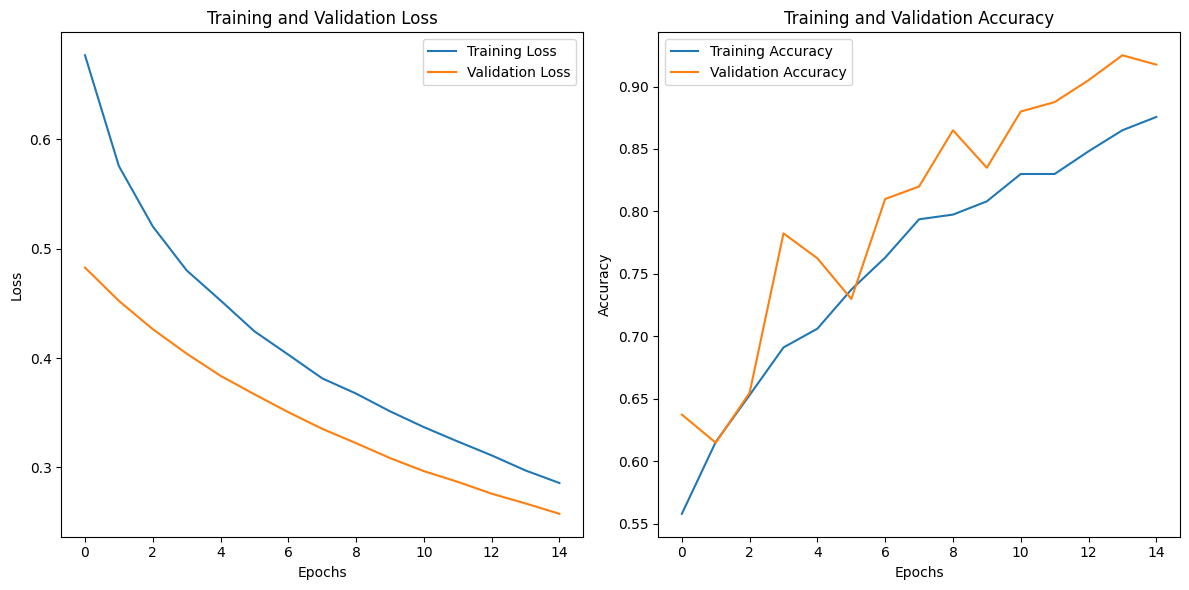

13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 211ms/step


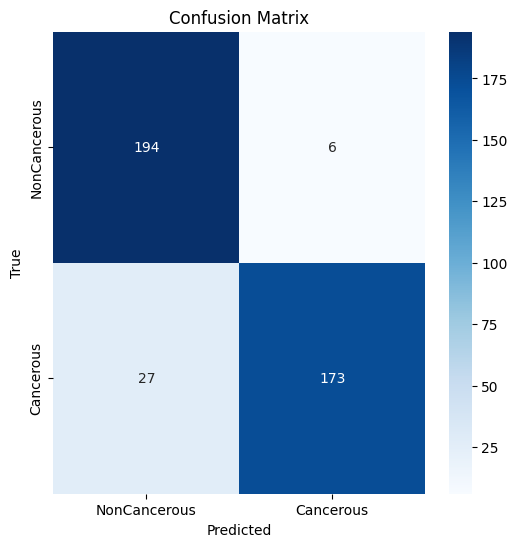

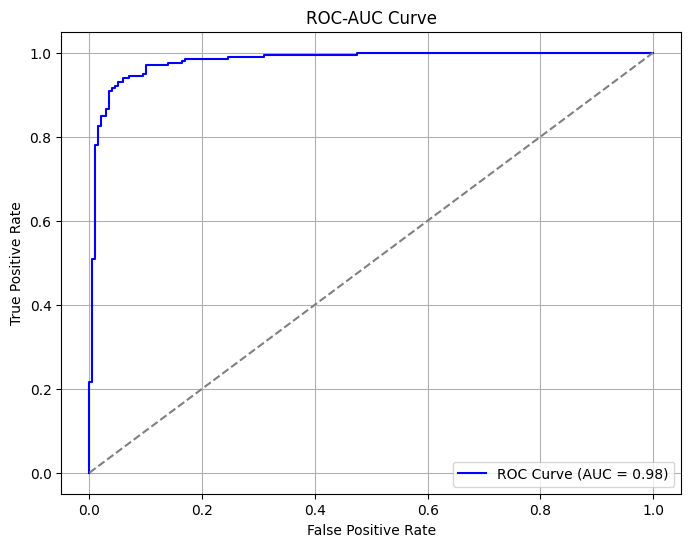


Classification Report:

              precision    recall  f1-score   support

      Normal       0.88      0.97      0.92       200
      Lesion       0.97      0.86      0.91       200

    accuracy                           0.92       400
   macro avg       0.92      0.92      0.92       400
weighted avg       0.92      0.92      0.92       400



In [ ]:
#Plot Training History
plot_training_history(history)


#Evaluate the model and generate predictions
y_pred = model.predict(test_dataset)
y_pred_classes = (y_pred > 0.5).astype("int32").flatten()  #If greater than 0.5, it assigns it as Lesion (1) and if less than 0.5 its assigned as normal (0)
y_true = np.concatenate([y for x, y in test_dataset], axis=0)  # Extract true labels from the dataset


#Confusion Matrix for Predictions (FP, FN, TP, TN)
plot_confusion_matrix(y_true, y_pred_classes)


#ROC-AUC Curve to show how well the model classifies between Normal and Lesion.
plot_roc_auc(y_true, y_pred)


#Classification Report - Precision, Recall, F1-score and Support
generate_classification_report(y_true, y_pred_classes)

# Version 3

changes:

*   More Data Augmentation (Rotation, Flipping, Cropping)
*   Partially Unfrozen ResNet50 (Last 30 Layers)
*   Stronger L2 Regularizer( 0.001 -> 0.003)
*   Higher droupout rate (0.5 -> 0.7)
*   Changing class weights, more emphasis on minority class
*   Using AdamW optimizer instead of Adam

In [9]:
# Create datasets
def preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])

    # Advanced Data Augmentation
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.rot90(image) if tf.random.uniform([]) > 0.5 else image  # Random 90-degree rotation
    image = tf.image.random_crop(image, size=[224, 224, 3])  # Random crop

    image = preprocess_input(image)  # ResNet50 preprocessing
    return image

def load_data(image_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(lambda x, y: (preprocess_image(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    return dataset

train_dataset = load_data(X_train, y_train).batch(32).shuffle(buffer_size=1000).prefetch(tf.data.AUTOTUNE)
test_dataset = load_data(X_test, y_test).batch(32).prefetch(tf.data.AUTOTUNE)

# Define the ResNet-50 model
def create_resnet_model():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Unfreeze last 30 layers for fine-tuning (reduced from 50)
    for layer in base_model.layers[-30:]:
        layer.trainable = True

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.003)),  # Stronger L2 Regularization
        layers.Dropout(0.7),  # Increased Dropout
        layers.Dense(1, activation='sigmoid')  # Binary classification
    ])
    return model

# Define Focal Loss Function
def focal_loss(alpha=0.25, gamma=2.0):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)
        cross_entropy = -y_true * K.log(y_pred) - (1 - y_true) * K.log(1 - y_pred)
        weight = alpha * y_true * K.pow(1 - y_pred, gamma) + (1 - alpha) * (1 - y_true) * K.pow(y_pred, gamma)
        loss = weight * cross_entropy
        return K.mean(loss)
    return focal_loss_fixed

# Compile the model
model = create_resnet_model()
model.compile(optimizer=AdamW(learning_rate=0.00005, clipnorm=1.0),  # Lower LR and Gradient Clipping
              loss=focal_loss(alpha=0.25, gamma=2.0),  # Use Focal Loss
              metrics=['accuracy'])

# Class Weights (handle class imbalance)
class_weights = {0: 1.0, 1: 4.0}  # Increase weight for Cancerous cases

# EarlyStopping and ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, min_lr=1e-6, verbose=1)

# Train the model
history = model.fit(train_dataset,
                    epochs=20,
                    validation_data=test_dataset,
                    class_weight=class_weights,
                    callbacks=[early_stopping, reduce_lr])

# Evaluate the model
test_loss, test_acc = model.evaluate(test_dataset)
print(f"\nTest accuracy: {test_acc:.2f}")

# Save the model
model_save_path = '/content/drive/MyDrive/skin_classification_resnet50_model.h5'
model.save(model_save_path)
print(f"\nModel saved to: {model_save_path}")


Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 102s 515ms/step - accuracy: 0.5408 - loss: 1.7852 - val_accuracy: 0.6150 - val_loss: 1.4179 - learning_rate: 5.0000e-05
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 42s 314ms/step - accuracy: 0.7135 - loss: 1.5010 - val_accuracy: 0.7150 - val_loss: 1.3872 - learning_rate: 5.0000e-05
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 42s 313ms/step - accuracy: 0.7536 - loss: 1.4255 - val_accuracy: 0.7650 - val_loss: 1.3412 - learning_rate: 5.0000e-05
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 40s 295ms/step - accuracy: 0.8216 - loss: 1.3613 - val_accuracy: 0.8325 - val_loss: 1.2902 - learning_rate: 5.0000e-05
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 41s 316ms/step - accuracy: 0.8879 - loss: 1.2898 - val_accuracy: 0.8650 - val_loss: 1.2598 - learning_rate: 5.0000e-05
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 23s 317ms/step - accuracy: 0.9369 - loss: 1.2186 - val_accuracy: 0.9175 - val_loss: 1.1898 - learning_rate: 5.0000e-05
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 38s 297ms/step - ac


Test accuracy: 0.98

Model saved to: /content/drive/MyDrive/skin_classification_resnet50_model.h5


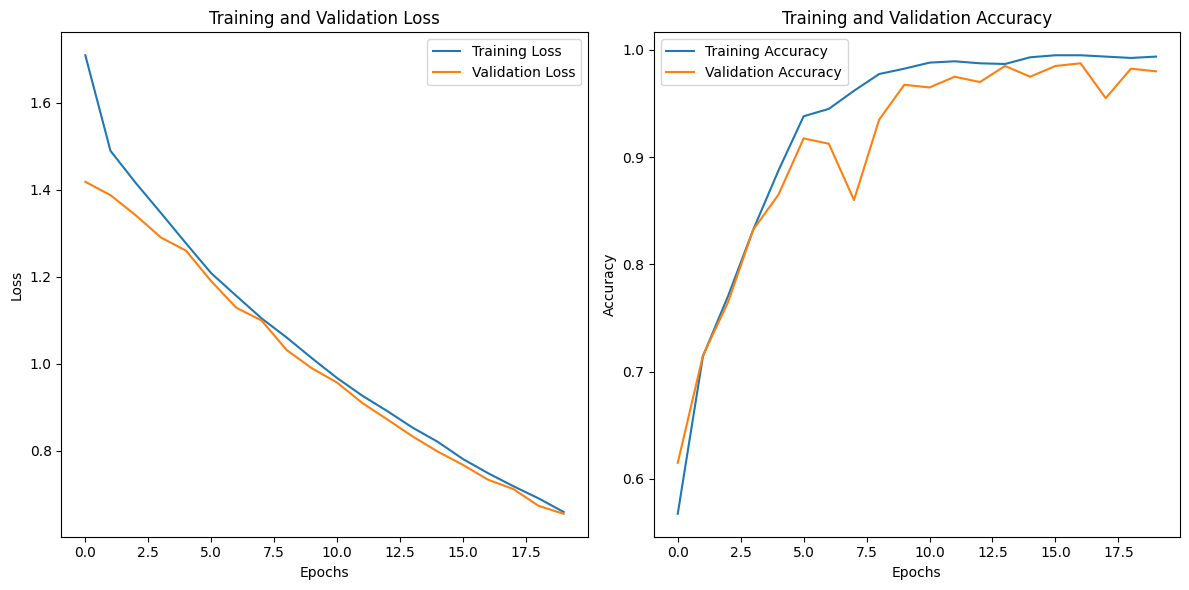

13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 477ms/step


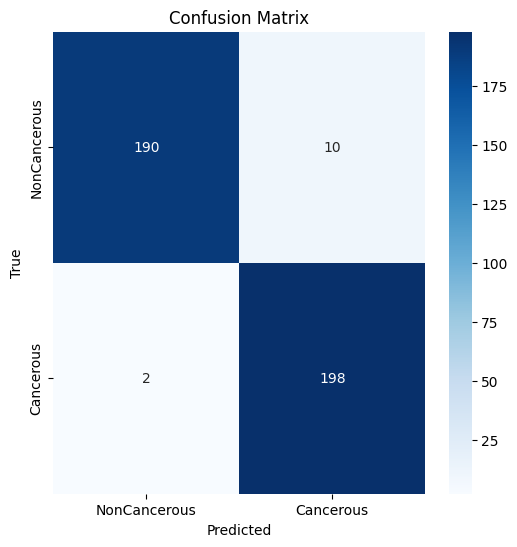

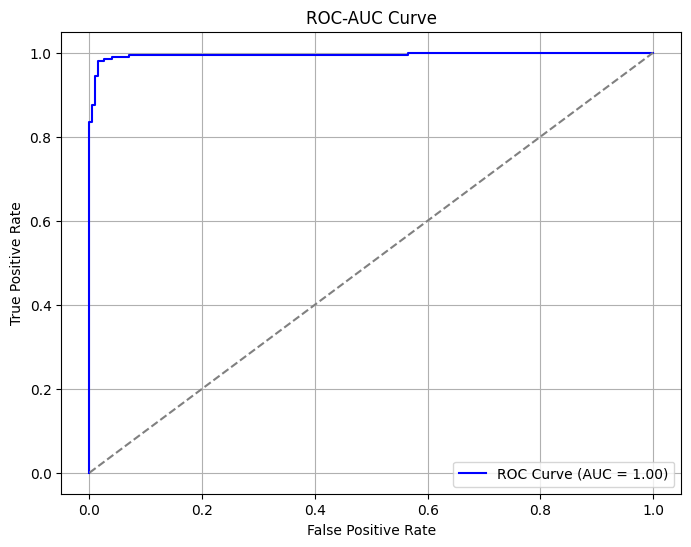


Classification Report:

              precision    recall  f1-score   support

NonCancerous       0.99      0.95      0.97       200
   Cancerous       0.95      0.99      0.97       200

    accuracy                           0.97       400
   macro avg       0.97      0.97      0.97       400
weighted avg       0.97      0.97      0.97       400



In [10]:
#Plot Training History
plot_training_history(history)


#Evaluate the model and generate predictions
y_pred = model.predict(test_dataset)
y_pred_classes = (y_pred > 0.5).astype("int32").flatten()  #If greater than 0.5, it assigns it as Lesion (1) and if less than 0.5 its assigned as normal (0)
y_true = np.concatenate([y for x, y in test_dataset], axis=0)  # Extract true labels from the dataset


#Confusion Matrix for Predictions (FP, FN, TP, TN)
plot_confusion_matrix(y_true, y_pred_classes)


#ROC-AUC Curve to show how well the model classifies between Normal and Lesion.
plot_roc_auc(y_true, y_pred)


#Classification Report - Precision, Recall, F1-score and Support
generate_classification_report(y_true, y_pred_classes)